In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
import warnings

warnings.filterwarnings('ignore')

# 设置字体为支持中文的字体，例如 SimHei
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False   # 正常显示负号
# 加载数据
# 数据预处理和加载
data = pd.read_excel('weatherofshanghai.xlsx')
data.fillna(method='ffill', inplace=True)
data['date'] = pd.to_datetime(data['date'])
features = ['平均温度', '平均湿度', '平均气压', '风速']
scaler = MinMaxScaler()

data_train = data[data['date'].dt.year < 2017]
data_test = data[data['date'].dt.year == 2017]
data_train[features] = scaler.fit_transform(data_train[features])
data_test[features] = scaler.transform(data_test[features])

SEQ_LENGTH = 10


def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i+seq_length][features].values
        target = data.iloc[i+seq_length][features].values
        X.append(seq)
        y.append(target)
    return np.array(X), np.array(y)


X, y_regression = create_sequences(data_train, SEQ_LENGTH)
X_test, y_regression_test = create_sequences(data_test, SEQ_LENGTH)

# 数据格式调整
X_cnn = X.transpose(0, 2, 1)  # 调整为 (samples, features, seq_length)
X_test_cnn = X_test.transpose(0, 2, 1)
X_cnn = X_cnn.astype(np.float32)
X_test_cnn = X_test_cnn.astype(np.float32)
y_regression = y_regression.astype(np.float32)
y_regression_test = y_regression_test.astype(np.float32)


class WeatherDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_dataset = WeatherDataset(X_cnn, y_regression)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# 定义纯CNN模型


class WeatherCNN(nn.Module):
    def __init__(self, input_channels, seq_length, output_size):
        super(WeatherCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=64, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * seq_length, 128)
        self.fc2 = nn.Linear(128, output_size)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        return self.fc2(x)




https://www.heywhale.com/mw/project/617a6486bbb4570017439dcc

In [2]:

cnn_model = WeatherCNN(input_channels=len(features), seq_length=SEQ_LENGTH, output_size=len(features))
criterion = nn.MSELoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.005)

# 训练
num_epochs = 200
print(f"Training CNN model")
for epoch in range(num_epochs):
    cnn_model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = cnn_model(X_batch)
        loss = criterion(outputs, y_batch)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch + 1}, Loss: {total_loss:.4f}")

Training CNN model
Epoch 50, Loss: 0.1925
Epoch 100, Loss: 0.0911
Epoch 150, Loss: 0.0566
Epoch 200, Loss: 0.0331


In [3]:
# 测试
cnn_model.eval()
with torch.no_grad():
    y_pred_regression_test = cnn_model(torch.tensor(X_test_cnn, dtype=torch.float32)).numpy()
    test_loss = criterion(torch.tensor(y_pred_regression_test), torch.tensor(y_regression_test)).item()
print(f'Test Loss: {test_loss:.6f}')

Test Loss: 0.023893


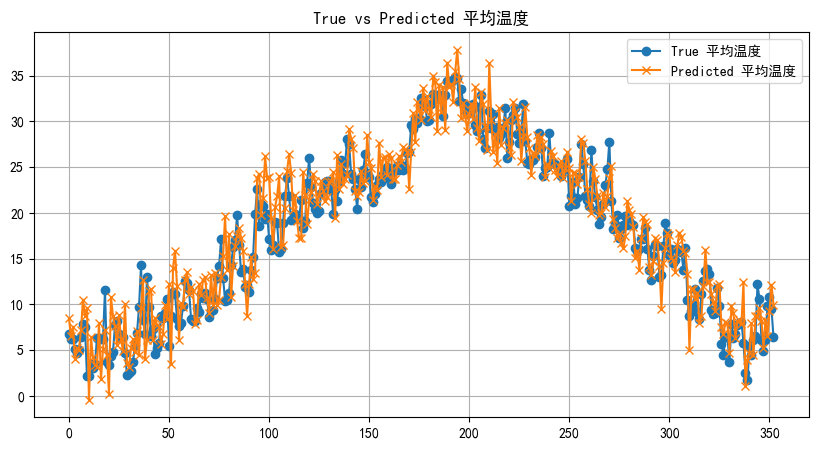

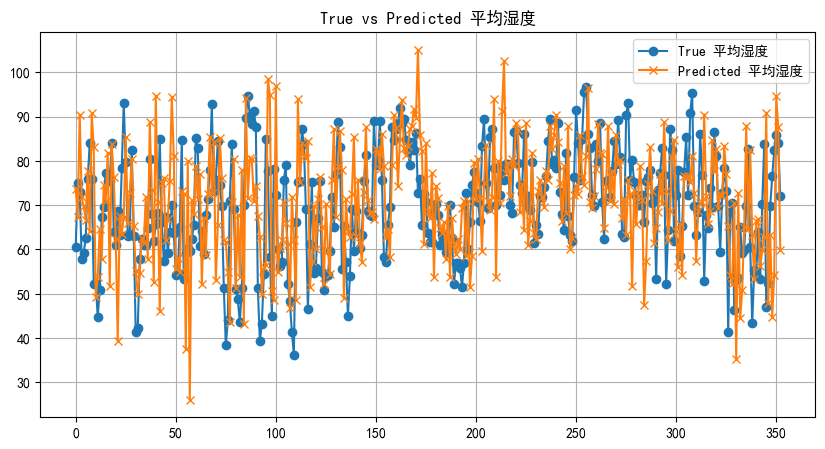

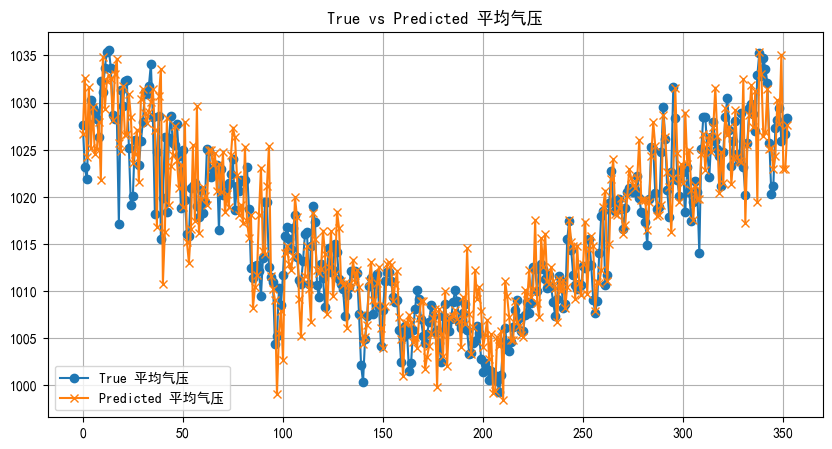

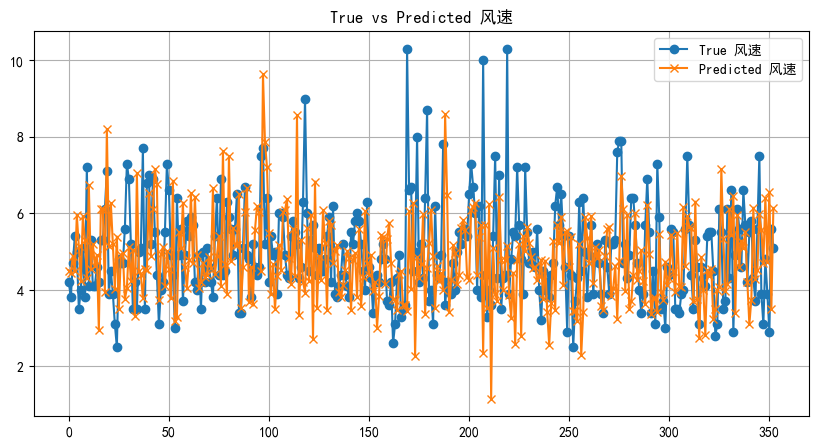

In [4]:

# 可视化


def plot_predictions(true_values, predicted_values, feature_names):
    for i, feature in enumerate(feature_names):
        plt.figure(figsize=(10, 5))
        plt.plot(true_values[:, i], label=f"True {feature}", marker='o')
        plt.plot(predicted_values[:, i], label=f"Predicted {feature}", marker='x')
        plt.title(f"True vs Predicted {feature}")
        plt.legend()
        plt.grid()
        plt.show()


y_true_original = scaler.inverse_transform(y_regression_test)
y_pred_original = scaler.inverse_transform(y_pred_regression_test)
plot_predictions(y_true_original, y_pred_original, features)